In [1]:
%matplotlib inline
from __future__ import division

from qiime.parse import parse_mapping_file
from qiime.format import format_mapping_file
from skbio.io.util import open_file
from itertools import product
from os.path import join
from biom import load_table

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
sns.set_context("poster")

def load_mf(fn):
    with open_file(fn, 'U') as f:
        mapping_data, header, _ = parse_mapping_file(f)
        _mapping_file = pd.DataFrame(mapping_data, columns=header)
        _mapping_file.set_index('SampleID', inplace=True)
    return _mapping_file

def write_mf(f, _df):
    with open_file(f, 'w') as fp:
        lines = format_mapping_file(['SampleID'] + _df.columns.tolist(),
                                    list(_df.itertuples()))
        fp.write(lines+'\n')

In [2]:
# Mathematica's default color list
colors = [(0.368417,0.506779,0.709798),
          (0.880722,0.611041,0.142051),
          (0.560181,0.691569,0.194885),
          (0.922526,0.385626,0.209179),
          (0.528488,0.470624,0.701351),
          (0.772079,0.431554,0.102387),
          (0.363898,0.618501,0.782349),
          (1,0.75,0),
          (0.647624,0.37816,0.614037),
          (0.571589,0.586483,0.),
          (0.915,0.3325,0.2125),
          (0.400822,0.522007,0.85),
          (0.972829,0.621644,0.073362),
          (0.736783,0.358,0.503027),
          (0.280264,0.715,0.429209)]
sns.set_palette(colors)

# Temporal Dynamics

In [5]:
from collections import defaultdict

import pandas as pd

def distances_and_labels_from_data(dm, df, patient_category='PATIENT_NUMBER',
                                   timepoint_category='TIMEPOINT_NUMBER',
                                   interest_category='IBD_TYPE'):
    """Return a list of lists of distances and the corresponding labels"""

    diff_ibd = defaultdict(list)

    output = pd.Series(index=df.index)
    
    for patient in df[patient_category].unique():
        # create a patient data frame
        patient_df = df[df[patient_category] == patient]

        # retrieve the sorted list of sample idenifiers
        sorted_ids = patient_df.sort_values(timepoint_category).index.tolist()

        # we are assuming all have the same value as
        # patients shouldn't change their IBD_TYPE
        ibd_type = patient_df[interest_category][0]

        # we go to len - 1 to account for the fact that
        # the first difference returns a series of N-1 length 
        for idx in range(len(sorted_ids)-1):
            a = patient_df.loc[sorted_ids[idx]][timepoint_category]
            b = patient_df.loc[sorted_ids[idx+1]][timepoint_category]
            # only day-to-day distances
            if (b-a) != 1:
                continue
                
            # get the distance between the timepoints from the distance matrix
            the_distance = dm[sorted_ids[idx], sorted_ids[idx+1]]
            diff_ibd[ibd_type].append(the_distance)
            output.loc[sorted_ids[idx]] = the_distance

    # defaultdicts are the devil cast to a regular dict
    diff_ibd = dict(diff_ibd)
    
    # put this into a format boxplots can understand
    dists, labels = [], []
    for k, v in diff_ibd.iteritems():
        labels.append(k)
        dists.append(np.asarray(v))
    
    return dists, labels, output

def format_latex(n):
    """Format a number ready for scientific notation in latex"""
    
    if n > 0.01:
        return str(n)
    
    val = r'%e' % n
    val = val.replace('e', r'x10^{')+'}'
    return val

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns

from os.path import join
from skbio import DistanceMatrix
from scipy.stats import mannwhitneyu

from collections import defaultdict


mf = load_mf('mapping-file.alpha.txt')
mf['days_since_epoch'] = pd.to_numeric(mf['days_since_epoch'], errors='coerce')

!mkdir -p 'analysis/beta/distributions-ibd-and-surgery/'
path = 'analysis/beta/distributions-ibd-and-surgery/'

# LOAD AS A CONVENIENCE
dm = DistanceMatrix.from_file('analysis/beta/unweighted_unifrac_dm.txt')

# cast to list because the tuple doesn't quite work
mf = mf.loc[list(dm.ids)]

filenames = ['analysis/beta/weighted_unifrac_dm.txt',
             'analysis/beta/unweighted_unifrac_dm.txt']
ylabels = ['Weighted UniFrac', 'Unweighted UniFrac']

for i in range(2):
    dm = DistanceMatrix.from_file(filenames[i])
    d, l, s = distances_and_labels_from_data(dm, mf, 'host_subject_id',
                                             'days_since_epoch', 'surgery_and_ibd')

    mf[ylabels[i] + ' timepoint distance'] = s

    # generate the stats
    print ylabels[i]
    base = 'Control'
    for cat in mf.surgery_and_ibd.unique():
        if cat != base:
            u, p = mannwhitneyu(mf[mf['surgery_and_ibd'] == base][ylabels[i] + ' timepoint distance'],
                                mf[mf['surgery_and_ibd'] == cat][ylabels[i] + ' timepoint distance'])
            print 'Controls vs %s p=%f u=%f' % (cat, p, u)

Weighted UniFrac
Controls vs Crohns p=0.001224 u=33677.000000
Controls vs Crohns (surgery) p=0.041120 u=24801.000000
Unweighted UniFrac
Controls vs Crohns p=0.000036 u=31825.000000
Controls vs Crohns (surgery) p=0.000000 u=16751.000000


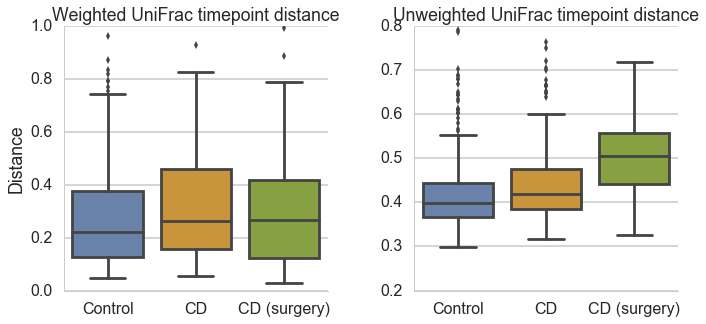

In [9]:
time_vars = ['Weighted UniFrac timepoint distance', 'Unweighted UniFrac timepoint distance']
melt_mf = pd.melt(mf, id_vars=['surgery_and_ibd'], value_vars=time_vars, value_name='Distance',
                  var_name='Metric')

rep = {'surgery_and_ibd': {'Crohns': 'CD', 'Crohns (surgery)': 'CD (surgery)'}}
g = sns.factorplot(x='surgery_and_ibd', y='Distance', col='Metric', data=melt_mf.replace(rep),
                   sharey=False, kind='box', size=5.2,
                   order=['Control', 'CD', 'CD (surgery)'])
g.set_titles(template='{col_name}')
g.set_xlabels('')
g.savefig('analysis/beta/distributions-ibd-and-surgery/figure4.pdf')

Writing out the mapping file with days since epoch:

In [12]:
mf.days_since_epoch = mf.days_since_epoch.astype(str, copy=True)
mf['Weighted UniFrac timepoint distance'] = mf['Weighted UniFrac timepoint distance'].astype(str, copy=True)
mf['Unweighted UniFrac timepoint distance'] = mf['Unweighted UniFrac timepoint distance'].astype(str, copy=True)

write_mf('mapping-file.alpha.distances.txt', mf)